# Imaging processing

---

As part of my STP, this is a learning project to achieve the competencies *Identify the need for a software application to support image processing and develop the prototype, document and comment appropriately* and *Test and, where possible, deploy the image processing software* of the module *Information and Communications Technology in the Clinical Environment*

I have used this Jupyter Notebook to explain step by step what I have done and to be able to save it as a PDF as evidence in my OneFile Portfolio. However, I have also created a repository in my GitHub account where I have created additional files such as a requeritment.txt document (to be able to run this script in other computers) and a README file where I explain how this script can be used. The link of this repo is https://github.com/Manuel-DominguezCBG/Reading_images

The motivation of this project is to convert data contained in a png file into a data frame such as an excel file or a CSV file. One of the geneticists came to us asking if we could do this conversion, she needed to analyze one of the tables generated by the programme GeneMarker®. For a reason I do not understand, this software provides the information in png files which is great for visualization but makes it impossible for further analysis. I have taken this opportunity to completed the two competencies mentioned above and become familiar with some imaging processing techniques what was at the beginning of this project completly new for me.

**The algorithm consists of four parts. You will find also a short reflection I have added about my experience working on this project.**

### 1. Preprocessing 

The table that contains the data we want to extract is found in a png document along with other tables and graphics. This first step consists of cutting that table and generating a new png file with it. In this first section, I have also added some code to increase the quality of the image such as invert the color of the image or change the size.

### 2. Cell recognition 

The approach I follow here has been to identify the cells of the table to finally create individual pictures for each cell. To finally used some library that recognizes the data of each image and converts the information of these pictures into strings of characters.

### 3. Text extraction  

The extraction of each allocated cell/image is performed by using Optical Character Recognition (OCR) with *pytesseract*.

### 4. Evaluation

By creating manually the same table, I have been able to evaluate the results. I have calculated in percentages the similarity between both data frames (the generate by this script and the manual one) to be able modify the parameters of my method and increase the accuracy as much as I can.


## 1. Preprocessing

In [1]:
# All libraries used
import cv2
import numpy as np
import pytesseract
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from pytesseract import image_to_string
from skimage import io
#from matplotlib.pyplot import figure
#import csv

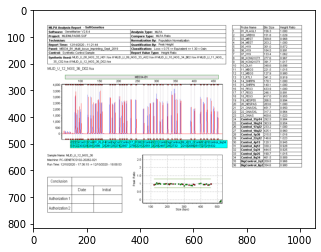

In [2]:
# First, Let´s display the image that has been given to me.
#im = io.imread("/Users/monkiky/Desktop/Reading_images/MLPA_Pg11_MLID_U_12_NGS_36_D02_Dye_Blue.png")
im = cv2.imread("/Users/monkiky/Desktop/Reading_images/Input/MLPA_Pg11_MLID_U_12_NGS_36_D02_Dye_Blue.png")
#plt.rcParams["figure.figsize"] = (20,20)
plt.imshow(im)
plt.show()

We want to read the table on the right side.

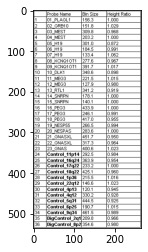

In [3]:
# Let´s select and display the table we want to read
# Manual cropped
cropped = im[55:590, 744:1010]
plt.imshow(cropped)

# Let´s make the image a little bit bigger
plt.rcParams["figure.figsize"] = (15,15)

# To save this table in a new png.
cv2.imwrite('/Users/monkiky/Desktop/Reading_images/output/cropped.png', cropped)
#plt.savefig('/Users/monkiky/Desktop/Reading_images/output/cropped.png')

# This is finally the image in which I am going to extract the data.
plt.show()

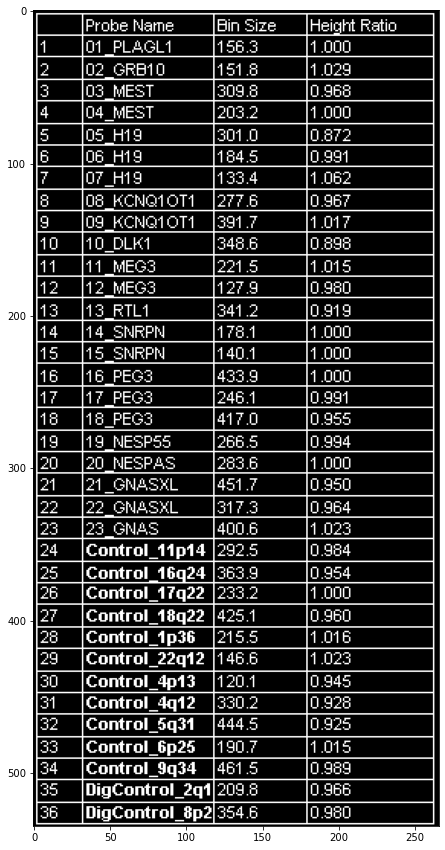

In [4]:
# Read the file we have just cropped
file=r'/Users/monkiky/Desktop/Reading_images/output/cropped.png'
img = cv2.imread(file,0)
img.shape

# To increase accuracy, it is a good idea to carry out thresholding and
# to then invert the image.
# I have seen that, this convertion not always increases accuracy.
# In fact, this convertion is beneficial for identifying the lines of my table
# But I wont use to identify the text.

# Explanation of thresholding the image to a binary image.

"""
This can be done with cv.threshold.
Thresholding is the simplest method of segmenting images. In some tutorials consulted, this is the right way 
to convert binary gray scale images into binary images. 
What thresholding does is basically to replace the color of every pixel into black or white depending on the intensity.
In this case if the pixel value is smaller than the threshold, 
it is set to 0, otherwise it is set to a maximum value. 
In the next line of code below,the first argument is the source image, which should be a grayscale image. 
The second argument is the threshold value which is used to classify the pixel values. 
The third argument is the maximum value which is assigned to pixel values exceeding the threshold.
The fourth parameter is for types of thresholding, in our case "THRESH_BINARY".
Finally, I have also applied an Otsu algorithm to choose the optimal threshold value.
"""

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# Then, we can invert the image. 
img_bin = 255-img_bin

"""
The convertion performed above and the following brlurring image processing is to carry out the identification of
the horizontal and vertical lines of the table. However, for the text recognision procesing, I have noticed that 
these imaging processing reduce the accuracy of the recognision so the final steps will take the cropped.png file
intead of the black-background image.
"""
blur = cv2.GaussianBlur(img_bin,(3,3),cv2.BORDER_DEFAULT)

# Now a few lines to plot the results we have carried out so far

cv2.imwrite('/Users/monkiky/Desktop/Reading_images/output/blur.png', blur)

cv2.imwrite('/Users/monkiky/Desktop/Reading_images/output/cv_inverted.png',img_bin)

plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

# Some extra code might be useful in future use of this programme...
# apply guassian blur on src image
#blur = cv2.GaussianBlur(cropped,(3,3),cv2.BORDER_DEFAULT)

## 2. Cell recognition

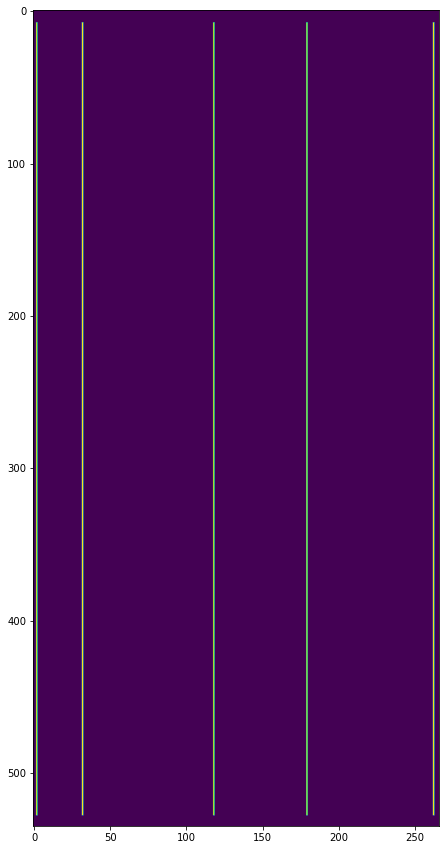

In [5]:
"""
We need to define a kernel to detect rectangular boxes, to finally identify the tabular structure. 
To do this, I first need to save horizontal and vertical lines in 2 jpg files that will be used later.
I also display this images because they are a good indicator of quality during the process.
If lines are not displayed, the tubular structure won´t be properly identified.
"""

# Width of kernel as 50th of total width
"""
Around 50 is the value that identifies only vertical lines of my table.
"""
kernel_len = np.array(img).shape[1]//50
# Defining a vertical kernel 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel 
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

# Now, we can save this kernel to identify the vertical lines and save them
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("/Users/monkiky/Desktop/Reading_images/output/vertical.jpg",vertical_lines)
#Plot the image with the vertical lines
plotting = plt.imshow(image_1)
plt.show()

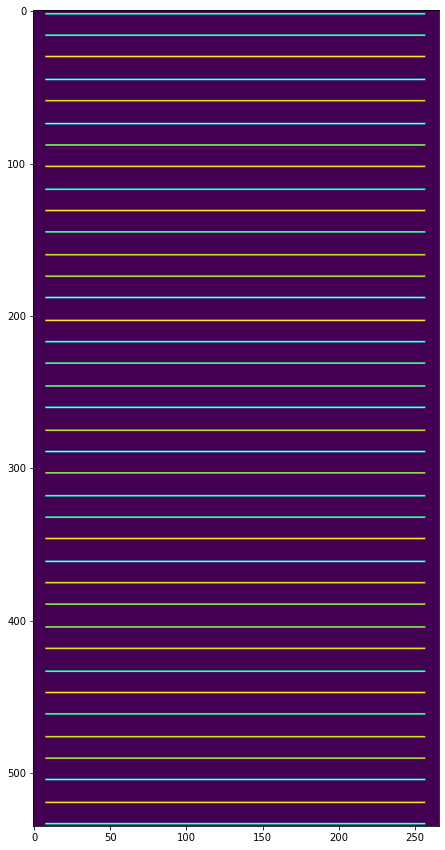

In [6]:
# Same with the horizontal ones.

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("/Users/monkiky/Desktop/Reading_images/output/horizontal.jpg",horizontal_lines)

#Plot the image with the horizaontal lines
plotting = plt.imshow(image_2)
plt.show()


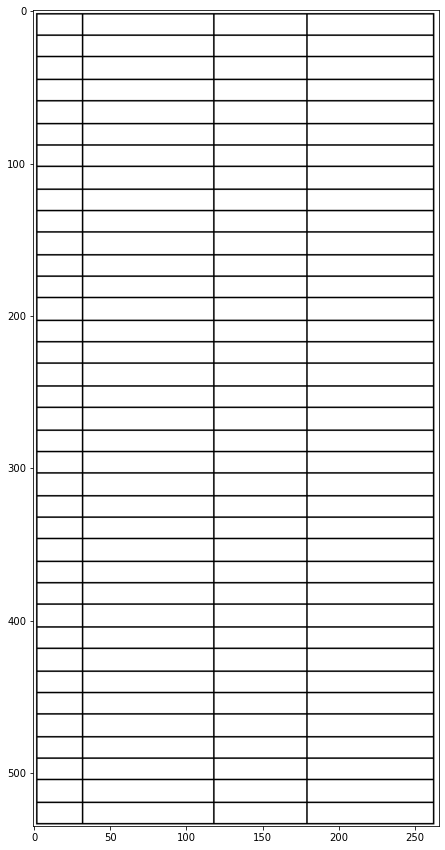

In [7]:
# Now, we just need to combine both jpg to build the table
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("/Users/monkiky/Desktop/Reading_images/output/img_vhe.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

#Plotting the generated image
#plotting = plt.imshow(bitnot,cmap='gray')
plotting = plt.imshow(img_vh, cmap='gray')
plt.show()

Pretty tabular structure

In [8]:
"""
Now, I need to identify cells. CV has a funtion that does exactly that, 
findContours function detects objects in an image.

To identify the relationship between boxes, we can use Contour Retrieval Modes, specifically 
the flag RETR_TREE which retrieves all the contours and creates a full family hierarchy list.

cv.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points. 
For example, an up-right rectangular contour is encoded with 4 points.

"""
# Detect contours for following box detection.
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Now, with this we can identify box by box from left to right and from top to bottom

def sort_contours(cnts, method="left-to-right"):
    
    
    """
    The first argument is the list of contours that we want to sort, 
    and the second is the sorting method, 
    which indicates the direction in which we are going to sort our contours
    """
    
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    
    # Handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
        
    # Handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        
    # Construct the list of bounding boxes and sort them
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# This function has been taken from https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/

In [9]:
# Sort all the boxes from top to bottom by using the last function
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

# Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)
boundingBoxes

((0, 0, 266, 535),
 (1, 1, 263, 534),
 (180, 3, 82, 13),
 (119, 3, 60, 13),
 (33, 3, 85, 13),
 (3, 3, 29, 13),
 (180, 17, 82, 13),
 (119, 17, 60, 13),
 (33, 17, 85, 13),
 (3, 17, 29, 13),
 (180, 31, 82, 14),
 (119, 31, 60, 14),
 (33, 31, 85, 14),
 (3, 31, 29, 14),
 (180, 46, 82, 13),
 (119, 46, 60, 13),
 (33, 46, 85, 13),
 (3, 46, 29, 13),
 (180, 60, 82, 14),
 (119, 60, 60, 14),
 (33, 60, 85, 14),
 (3, 60, 29, 14),
 (180, 75, 82, 13),
 (119, 75, 60, 13),
 (33, 75, 85, 13),
 (3, 75, 29, 13),
 (180, 89, 82, 13),
 (119, 89, 60, 13),
 (33, 89, 85, 13),
 (3, 89, 29, 13),
 (180, 103, 82, 14),
 (119, 103, 60, 14),
 (33, 103, 85, 14),
 (3, 103, 29, 14),
 (180, 118, 82, 13),
 (119, 118, 60, 13),
 (33, 118, 85, 13),
 (3, 118, 29, 13),
 (180, 132, 82, 13),
 (119, 132, 60, 13),
 (33, 132, 85, 13),
 (3, 132, 29, 13),
 (180, 146, 82, 14),
 (119, 146, 60, 14),
 (33, 146, 85, 14),
 (3, 146, 29, 14),
 (180, 161, 82, 13),
 (119, 161, 60, 13),
 (33, 161, 85, 13),
 (3, 161, 29, 13),
 (180, 175, 82, 13),
 

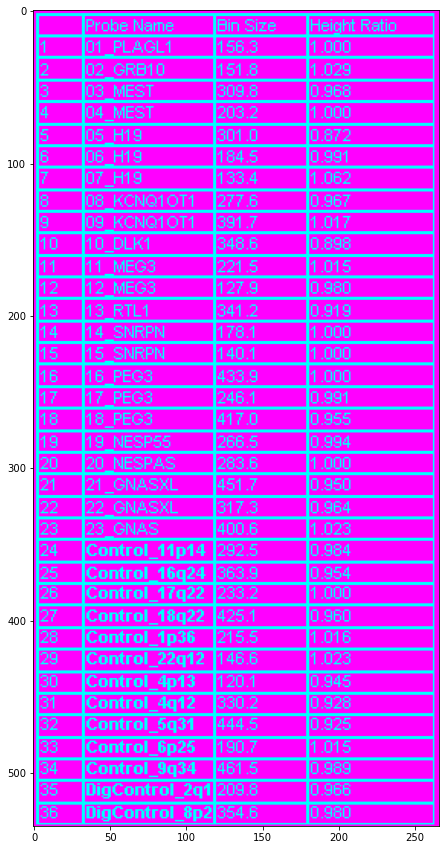

In [10]:
# Sort all the boxes from top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every box and show the box on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
        box.append([x,y,w,h])
        
plotting = plt.imshow(image,cmap='cool')
plt.show()


In [11]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0

#Sorting the boxes to their respective row and column
for i in range(len(box)):    
        
    if(i==0):
        column.append(box[i])
        previous=box[i]    
    
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]            
            
            if(i==len(box)-1):
                row.append(column)        
            
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
# These are the coordinates of every box found in the table
print(column)
print(row)

These are the coordinates of every boxes found in the table
[[180, 520, 82, 13], [119, 520, 60, 13], [33, 520, 85, 13], [3, 520, 29, 13]]
[[[180, 3, 82, 13], [119, 3, 60, 13], [33, 3, 85, 13], [3, 3, 29, 13]], [[180, 17, 82, 13], [119, 17, 60, 13], [33, 17, 85, 13], [3, 17, 29, 13]], [[180, 31, 82, 14], [119, 31, 60, 14], [33, 31, 85, 14], [3, 31, 29, 14]], [[180, 46, 82, 13], [119, 46, 60, 13], [33, 46, 85, 13], [3, 46, 29, 13]], [[180, 60, 82, 14], [119, 60, 60, 14], [33, 60, 85, 14], [3, 60, 29, 14]], [[180, 75, 82, 13], [119, 75, 60, 13], [33, 75, 85, 13], [3, 75, 29, 13]], [[180, 89, 82, 13], [119, 89, 60, 13], [33, 89, 85, 13], [3, 89, 29, 13]], [[180, 103, 82, 14], [119, 103, 60, 14], [33, 103, 85, 14], [3, 103, 29, 14]], [[180, 118, 82, 13], [119, 118, 60, 13], [33, 118, 85, 13], [3, 118, 29, 13]], [[180, 132, 82, 13], [119, 132, 60, 13], [33, 132, 85, 13], [3, 132, 29, 13]], [[180, 146, 82, 14], [119, 146, 60, 14], [33, 146, 85, 14], [3, 146, 29, 14]], [[180, 161, 82, 13], [11

In [12]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

#Retrieving the centre of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

center=np.array(center)
center.sort()

#Regarding the distance to the columns centre, the boxes are arranged in respective order

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

## 3. Text extraction 

In [13]:
# We increase the accuracy of your text recognition 
# if we previously specify the characters that the programme will find
alpha = "-c tessedit_char_whitelist=01234567890ABCDEFGHIJKLMNOPQRSTUVWXYZ_. --psm 6"

In [14]:
#From every single image-based cell/box the strings are extracted via pytesseract and stored in a list

pictures = []
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                # Save the images of each box to analyze that everything has gone well and analyze 
                # why some values are not recognized correctly
                cv2.imwrite('/Users/monkiky/Desktop/Reading_images/output/boxes/' + str(i) + str(j) +'.png', finalimg)

                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                
                # Different parameters we can use to alter recognition:
                
                #border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                #resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                #dilation = cv2.dilate(resizing, kernel,iterations=1)
                #erosion = cv2.erode(dilation, kernel,iterations=2)
                
                # Character recognition
                out = pytesseract.image_to_string(finalimg, config=alpha)
               # if(len(out)==0):
                 #   out = pytesseract.image_to_string(erosion, config=alpha)
                inner = inner +" "+ out
            outer.append(inner)

#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
#print(dataframe)
extracted = dataframe.style.set_properties(align="left")
extracted
#Converting it in a excel-file
#data.to_excel("/Users/monkiky/Desktop/Reading_images/output/img_vhe.jpg")

,0,1,2,3
0,,PN_,BS,HR
1,1,01_PLAGL1,156.3,4.000
2,2,02_GRB1O.,1518,4.029
3,3,03_MEST,309.8,0.968
4,4,O04_MEST,203.2,4.000
5,5,05H19,301.0,0.872
6,6,06H19,1845,0.991
7,7,O7_H19,133.4,1.062
8,8,08_KCNQ10T1,VIB,0.967
9,9,09_KCNQ10T1,391.7,41.017


## Evaluation
Let´s evaluate how good our methods are by comparing the data frame generated with a data frame I am going to create manually. 

In [38]:
# Let's modify first the extracted data to be able to do some comparison
# I dont know why this is a styler df
extracted0 = extracted.data # data frame styler object into dataframe 
extracted0.head()


,0,1,2,3
0,,PN_\n,BS\n,HR\n
1,1\n,01_PLAGL1\n,156.3\n,4.000\n
2,2\n,02_GRB1O.\n,1518\n,4.029\n
3,3\n,03_MEST\n,309.8\n,0.968\n
4,4\n,O04_MEST\n,203.2\n,4.000\n


In [39]:
# Let´s delete the newline character '\n'
extracted0 = extracted0.replace('\n', '', regex=True)
extracted0 = extracted0.replace(' ', '', regex=True)
extracted0 = extracted0.replace("\s", "", regex=True) # To remove trailing whitespaces
extracted0 = extracted0.applymap(str)

extracted0.head()

,0,1,2,3
0,,PN_,BS,HR
1,1,01_PLAGL1,156.3,4.000
2,2,02_GRB1O.,1518,4.029
3,3,03_MEST,309.8,0.968
4,4,O04_MEST,203.2,4.000


In [40]:
extracted0 = extracted0.iloc[1:]
extracted0.columns =['index_E', 'Probe_Name_E', 'Bin_Size_E', 'Heigth_Ratio_E'] 
extracted0

,index_E,Probe_Name_E,Bin_Size_E,Heigth_Ratio_E
1,1,01_PLAGL1,156.3,4.000
2,2,02_GRB1O.,1518,4.029
3,3,03_MEST,309.8,0.968
4,4,O04_MEST,203.2,4.000
5,5,05H19,301.0,0.872
6,6,06H19,1845,0.991
7,7,O7_H19,133.4,1.062
8,8,08_KCNQ10T1,VIB,0.967
9,9,09_KCNQ10T1,391.7,41.017
10,10,10_DLK1,348.6,0.898


In [41]:
# Last modification, reset.index that establishes the index starting from 0
# but also creates a new column called "index" that I delete.
extracted0 = extracted0.reset_index().drop('index', 1)
extracted0.head()


,index_E,Probe_Name_E,Bin_Size_E,Heigth_Ratio_E
0,1,01_PLAGL1,156.3,4.000
1,2,02_GRB1O.,1518,4.029
2,3,03_MEST,309.8,0.968
3,4,O04_MEST,203.2,4.000
4,5,05H19,301.0,0.872


In [42]:
# This is the data frame I have created manually.
manual_data = {'index_C': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36],
           "Probe_Name_C": ["01_PLAGL1","02_GRB10","03_MEST","04_MEST","05_H19","06_H19","07_H19","08_KCNQ1OT1","09_KCNQ1OT1","10_DLK1","11_MEG3","12_MEG3","13_RTL1","14_SNRPN","15_SNRPN","16_PEG3","17_PEG3","18_PEG3","19_NESP55","20_NESPAS","21_GNASXL","22_GNASXL","23_GNAS","Control_11p14","Control_16q24","Control_17q22","Control_18q22","Control_1p36","Control_22q12","Control_4p13,","Control_4q12","Control_5q31","Control_6p25","Control_9q34","DigControl_2q1","DigControl_8p2"],
           "Bin_Size_C": [156.3,151.8,309.8,203.2,301.0,184.5,133.4,277.6,391.7,348.6,221.5,127.9,341.2,178.1,140.1,433.9,246.1,417.0,266.5,283.6,451.7,317.3,400.6,292.5,363.9,233.2,425.1,215.5,146.6,120.1,330.2,444.5,190.7,461.5,209.8,354.6],
           "Heigth_Ratio_C": [1.000,1.029,0.968,1.000,0.872,0.991,1.062,0.967,1.017,0.898,1.015,0.980,0.919,1.000,1.000,1.000,0.991,0.955,0.994,1.000,0.950,0.964,1.023,0.984,0.954,1.000,0.960,1.016,1.023,0.945,0.928,0.925,1.015,0.989,0.966,0.980]}
Control = pd.DataFrame(data=manual_data)
Control = Control.applymap(str)
print(Control.head())

  index_C Probe_Name_C Bin_Size_C Heigth_Ratio_C
0       1    01_PLAGL1      156.3            1.0
1       2     02_GRB10      151.8          1.029
2       3      03_MEST      309.8          0.968
3       4      04_MEST      203.2            1.0
4       5       05_H19      301.0          0.872


In [43]:
comparative_df = pd.concat([Control, extracted0], axis=1)
comparative_df.head()

,index_C,Probe_Name_C,Bin_Size_C,Heigth_Ratio_C,index_E,Probe_Name_E,Bin_Size_E,Heigth_Ratio_E
0,1,01_PLAGL1,156.3,1.0,1,01_PLAGL1,156.3,4.000
1,2,02_GRB10,151.8,1.029,2,02_GRB1O.,1518,4.029
2,3,03_MEST,309.8,0.968,3,03_MEST,309.8,0.968
3,4,04_MEST,203.2,1.0,4,O04_MEST,203.2,4.000
4,5,05_H19,301.0,0.872,5,05H19,301.0,0.872


In [49]:
comparative_df['comparative_index'] = np.where(comparative_df['index_C']==comparative_df['index_E'], 
                                           'yes', 'no')

comparative_df['comparative_Probe'] = np.where(comparative_df['Probe_Name_C']==comparative_df['Probe_Name_E'], 
                                           'yes', 'no')

comparative_df['comparative_Bin'] = np.where(comparative_df['Bin_Size_C']==comparative_df['Bin_Size_E'], 
                                           'yes', 'no')

comparative_df['comparative_Height'] = np.where(comparative_df['Heigth_Ratio_C']==comparative_df['Heigth_Ratio_E'], 
                                           'yes', 'no')

comparative_df

,index_C,Probe_Name_C,Bin_Size_C,Heigth_Ratio_C,index_E,Probe_Name_E,Bin_Size_E,Heigth_Ratio_E,comparative_index,comparative_Probe,comparative_Bin,comparative_Height
0,1,01_PLAGL1,156.3,1.0,1,01_PLAGL1,156.3,4.000,yes,yes,yes,no
1,2,02_GRB10,151.8,1.029,2,02_GRB1O.,1518,4.029,yes,no,no,no
2,3,03_MEST,309.8,0.968,3,03_MEST,309.8,0.968,yes,yes,yes,yes
3,4,04_MEST,203.2,1.0,4,O04_MEST,203.2,4.000,yes,no,yes,no
4,5,05_H19,301.0,0.872,5,05H19,301.0,0.872,yes,no,yes,yes
5,6,06_H19,184.5,0.991,6,06H19,1845,0.991,yes,no,no,yes
6,7,07_H19,133.4,1.062,7,O7_H19,133.4,1.062,yes,no,yes,yes
7,8,08_KCNQ1OT1,277.6,0.967,8,08_KCNQ10T1,VIB,0.967,yes,no,no,yes
8,9,09_KCNQ1OT1,391.7,1.017,9,09_KCNQ10T1,391.7,41.017,yes,no,yes,no
9,10,10_DLK1,348.6,0.898,10,10_DLK1,348.6,0.898,yes,yes,yes,yes


In [62]:
# % of matches between columns
index = (((comparative_df['comparative_index'].value_counts()[0])/34)*100)
Probe = (((comparative_df['comparative_Probe'].value_counts()[0])/34)*100)
Bin = (((comparative_df['comparative_Bin'].value_counts()[0])/34)*100)
Height = (((comparative_df['comparative_Height'].value_counts()[0])/34)*100)

In [64]:
print("% of matches between index columns: ", index)
print("% of matches between Probe_Name columns: ", Probe)
print("% of matches between Bin_Size columns: ", Bin)
print("% of matches between Heigth_Ratio columns: ", Height)

print ("Total % of matches: ", (index+Probe+Bin+Height)/4)

% of matches between index columns:  94.11764705882352
% of matches between Probe_Name columns:  79.41176470588235
% of matches between Bin_Size columns:  70.58823529411765
% of matches between Heigth_Ratio columns:  64.70588235294117
Total % of matches:  77.20588235294117


## Reflection



This has been an interesting first approach of what is to work with images. I have been working with Python for around 2 years, but never processing images. Originally I thought that this would be more difficult until I understood how a picture is formed. Basically, each pixel is formed by a numeric representation of its intensity that is an output from its two-dimensional functions fed as input by its spatial coordinates.


Second, the most import learning element of this project has been the strategy I have developed. I started reading documentation and tutorials on how this can be carry out to finally apply this knowledge to extract data from a table contained in a pgn file. There is more than one library that from a giving image recognise text, but my goal was to be able to do that from a table what is a little bit more complicated. I have combined different tutorial plus some own development process and suggestion of my supervisor to do this.

It has been also interesting to try to understand how the text recognition library works. For example how this programme is good when you try to recognise words like "Hello" or "London" but but presents a lack of accuracy when you need to recognise a set of characters you don't find in an English dictionary such as it Control_11p14 or 19_NESP55. For that reason, in the first input of the Text extraction part, you can see how I have specified and limited the characters that the programme can find in my input png to be able to increase the accuracy. Anyway, as it can be seen in the total percentages of matches, this is far away to be perfect. I have not been able to recognise more than the 77% of the total number of cells contained in the table. One thing I would like to do in the future is to repeat the same I have done here but with real words and compare the efficiency of this algorithm.

Apart from learning what is the kernel or the process Thresholding, another formative point was the processing I have done at the beginning of this Notebook to increase the recognition of the algorithm. In the line recognition I did to identify the cells of the table I needed to brured otherwise the programme considered the character 1 as a line. And on the contrary, to recognise character, any pre processing was done. So, not always the best quality image produces the best results.